The RFM model provides a deterministic description of the value of each customer in term of the purchase behaviour. 
The metrics chosen to describe the customer behaviours are:
1) RECENCY: How recently does the customer purchase the last time?
2) FREQUENCY: How often does the customer purchase?
3) MONETARY VALUE: How much money does the customer spend?

Typically one express the RFM value either as a numerical scores (e.g. 1 to 10) or as a business-understandable 
categories(e.g. Diamond, Gold, Silver, Bronze, …).

The first step in constructing the RFM categories is to refine the customer base perimeter by dividing customer in 
inactive or lost, i.e. those customers who are not purchasing for a significantly long time, and active.
The RFM category associated to inactive customer is simply “inactive”.
To quantify what is meant for “a significantly long time”, it must defines a threshold:
the cut point is defined looking at the Next Day Purchase Curve. 

(Next Day Purchase Curve = number of days such that the 80-90% of the customers repurchase within this time interval from last purchase.)

One then construct the so called RF-matrix:
The recency and frequency percentile groups are combined to define new classes describing the customers loyalty status.

Finally, the RFM-classes are obtained by combining the RF-classeswith the Monetary Value groups.


In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import squarify
import datetime


In [2]:
from google.colab import drive
drive.mount('/content/drive') 

BASE_PATH = '/content/drive/MyDrive/Progetto_Web/Dataset_Clean/'

Import datasets previously cleaned (Look at Data Preparation)

In [3]:
df = pd.read_csv(BASE_PATH + 'df7.csv', decimal = ',', 
                 encoding = 'latin-1')
df.head()

,ID_SCONTRINO,ID_CLI,ID_NEG,ID_ARTICOLO,COD_REPARTO,DIREZIONE,DATETIME,ORA,DATA,IMPORTO_NETTO
0,51399406901/05/18718488528430,324419,47,36167733,9,1,2018-05-01 07:18:48,7,2018-05-01 00:00:00,799.0
1,511499219301/05/18718488544998,332611,36,32404540,13,1,2018-05-01 07:18:48,7,2018-05-01 00:00:00,99.9
2,511599623601/05/18718498530796,325589,35,35811412,9,1,2018-05-01 07:18:49,7,2018-05-01 00:00:00,399.0
3,511599623601/05/18718498530796,325589,35,35811741,9,1,2018-05-01 07:18:49,7,2018-05-01 00:00:00,474.0
4,513299487901/05/18719013919165,56975,20,36167733,9,1,2018-05-01 07:19:01,7,2018-05-01 00:00:00,799.0


In [4]:
## Change columns type 
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df[['COD_REPARTO', 'DIREZIONE']] = df[['COD_REPARTO', 'DIREZIONE']].apply(lambda x: x.astype('category'))
df['IMPORTO_NETTO'] = df['IMPORTO_NETTO'].astype(float) 
df.dtypes

ID_SCONTRINO             object
ID_CLI                    int64
ID_NEG                    int64
ID_ARTICOLO               int64
COD_REPARTO            category
DIREZIONE              category
DATETIME         datetime64[ns]
ORA                       int64
DATA                     object
IMPORTO_NETTO           float64
dtype: object

<!-- Features: 
1) ID_SCONTRINO = Purchase tracking number
2) ID_CLI = Customer tracking number
3) ID_NEG = Shop tracking number
4) COD_REPARTO = Unit tracking number
5) DIREZIONE = purchase (+1) or return (-1)
6) IMPORTO_LORDO = Gross amount
7) SCONTO = discount
8) DATETIME = Purchase date -->

In [5]:
## Upload the dataset containing customers informations
df_1 = pd.read_csv('df1_zip.csv', decimal = ',', 
                   encoding = 'latin-1', compression = 'gzip')
df_1.head(5)

,ID_CLI,ID_FID,LAST_COD_FID,LAST_TYP_CLI_FID,LAST_STATUS_FID,LAST_DT_ACTIVE,FIRST_ID_NEG,FIRST_DT_ACTIVE,NUM_FIDs
0,199060,928121,PREMIUM BIZ,1,1,2019-05-11,19,2018-02-18,2
1,613049,928118,PREMIUM,1,1,2019-05-11,21,2019-03-30,2
2,648813,928116,STANDARD,1,1,2019-05-10,1,2018-10-27,3
3,914880,928115,STANDARD,1,1,2019-05-10,43,2019-04-15,2
4,342639,928112,PREMIUM BIZ,1,1,2019-05-09,26,2018-04-29,2


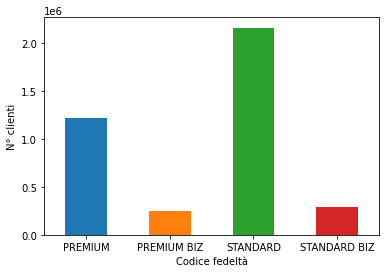

In [6]:
## Fidelity type about customers with purchases informations
merge_df_df1 = pd.merge(df, df_1, on = 'ID_CLI').rename(columns={'ID_NEG_y': 'ID_NEG'})
merge_df_df1.reset_index(inplace = True, drop = True)
data = merge_df_df1.groupby('LAST_COD_FID', as_index=False).agg(Count = ('DATETIME', 'count'))

color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

## Plot
data.plot.bar(x='LAST_COD_FID', 
              y='Count', 
              rot=0,
              color = color,
              legend = None,
              ylabel = 'N° clienti',
              xlabel = 'Codice fedeltà'
             )
plt.savefig('Fidelity Customers.png')


## Customers often have standard or premium class fidelity

### RECENCY = days passed from last purchase for each customer
First of all we set a cut point in order to divide customer base into active and inactive.
The cut point is choosen considering the next purchase curve

The cut point date is fixed at 2019-02-19.
So we consider as inactive the purchases over the 85th percentile, that is over 69 days from the last purchase.

In [7]:
## Split dataset into active and inactive
## Drop negatives IMPORT_NETTO values
df_active = df[df['DATETIME'] > datetime.datetime.strptime('2019-02-19', '%Y-%m-%d')]
df_active.head(50)

,ID_SCONTRINO,ID_CLI,ID_NEG,ID_ARTICOLO,COD_REPARTO,DIREZIONE,DATETIME,ORA,DATA,IMPORTO_NETTO
2904080,513546271419/02/19659289145776,636660,17,35758590,2,1,2019-02-19 06:59:28,6,2019-02-19 00:00:00,659.00
2904081,51115195819/02/19659409427016,773705,49,35842590,4,1,2019-02-19 06:59:40,6,2019-02-19 00:00:00,3.50
2904082,51115195819/02/19659409427016,773705,49,32497920,10,1,2019-02-19 06:59:40,6,2019-02-19 00:00:00,2.60
2904083,51115195819/02/19659409427016,773705,49,33348714,11,1,2019-02-19 06:59:40,6,2019-02-19 00:00:00,4.99
2904084,515520595419/02/19711159326970,727605,2,36103816,2,1,2019-02-19 07:11:15,7,2019-02-19 00:00:00,233.90
2904085,515520595419/02/19711159326970,727605,2,36104131,2,1,2019-02-19 07:11:15,7,2019-02-19 00:00:00,701.70
2904086,515520595419/02/19711159326970,727605,2,34406785,10,1,2019-02-19 07:11:15,7,2019-02-19 00:00:00,67.60
2904087,515520595419/02/19711159326970,727605,2,35761950,10,1,2019-02-19 07:11:15,7,2019-02-19 00:00:00,5.50
2904088,515520595419/02/19711159326970,727605,2,34067341,11,1,2019-02-19 07:11:15,7,2019-02-19 00:00:00,1.99
2904089,515520595419/02/19711159326970,727605,2,35075523,11,1,2019-02-19 07:11:15,7,2019-02-19 00:00:00,7.65


In [8]:
## Create snapshot date to calculate the recency.
## The date difference will give us how recent the last transaction is.
snapshot_date = df_active['DATETIME'].max()
print('snapshot_date = ' + str(snapshot_date))

## Grouping by CustomerID
## Frequency = count(Id_scontrino)
## Recency = last day available - last purchase day for customers
## Monetary value = IMPORTO_LORDO - SCONTO = IMPORTO_NETTO

dt = df_active.groupby(['ID_CLI']).agg({
        'DATETIME': lambda x: (snapshot_date - x.max()).days,
        'ID_SCONTRINO': 'count',
        'IMPORTO_NETTO': 'sum'})

## Rename the columns 
dt.rename(columns={'DATETIME': 'Recency',
                   'ID_SCONTRINO': 'Frequency',
                   'IMPORTO_NETTO': 'MonetaryValue'}, inplace=True)

snapshot_date = 2019-04-30 21:57:25


## Plot RFM distribution

C:\Users\Tommi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Tommi\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\Tommi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Tommi\anaconda3\lib\site-packages\seaborn\distr

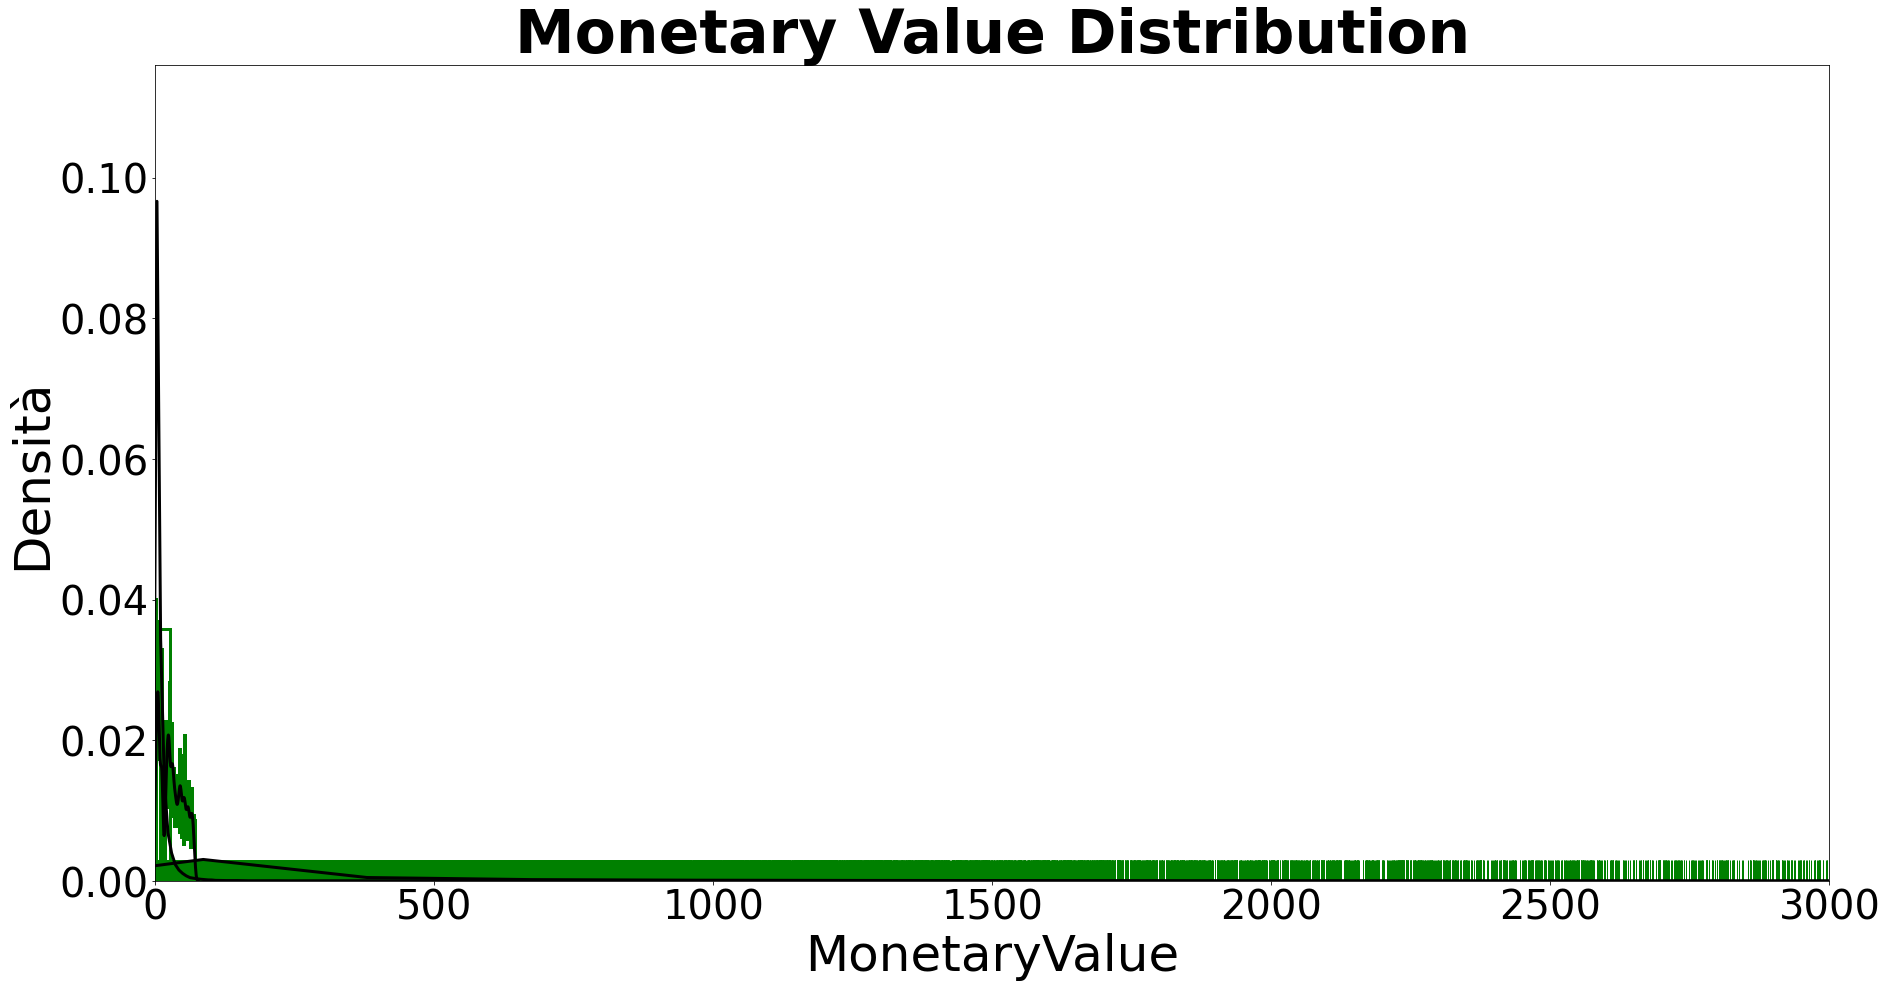

In [45]:
plt.figure(figsize=(30,15))

# Plot distribution of R
ax = sns.distplot(dt['Recency'], rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"},
                 axlabel='Recency', 
                 )
                 
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.xlabel('Recency', fontsize=50)
plt.ylabel('Densità', fontsize=50)
plt.title("Recency Distribution",fontsize=60,fontweight="bold")
plt.savefig('Distribution R.png')

# Plot distribution of F
ax = sns.distplot(dt['Frequency'], rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"},
                 axlabel='Frequency', 
                 )

plt.xlim([0,400])
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.ylabel('Densità', fontsize=50)
plt.title("Frequency Distribution",fontsize=60,fontweight="bold")
plt.savefig('Distribution F.png')

# Plot distribution of M
ax = sns.distplot(dt['MonetaryValue'], rug=True,
                  rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"},
                 axlabel='MonetaryValue' 
                 )

plt.xlim([0,3000])
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.xlabel('MonetaryValue', fontsize=50)
plt.ylabel('Densità', fontsize=50)
plt.title("Monetary Value Distribution",fontsize=60,fontweight="bold")
plt.savefig('Distribution M.png')

### Calculating R, F and M groups

In [ ]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)

# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(dt['Recency'], q=4, labels=r_labels)

# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(dt['Frequency'], q=4, labels=f_labels)

# Create labels for MonetaryValue
m_labels = range(1, 5)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(dt['MonetaryValue'], q=4, labels=m_labels)


# Create new columns R and F 
DT_PROCESS = dt.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

## Assign 'Low', 'Medium', 'High' to each RFM values
def class_transform(x):
    if x == 1:
        return 'Low'
    if (x > 1) & (x <= 3):
        return 'Medium'
    if x == 4:
        return  'High'
        
DT_PROCESS['R Classes'] = DT_PROCESS.R.apply(lambda x:class_transform(x)) 
DT_PROCESS['F Classes'] = DT_PROCESS.F.apply(lambda x:class_transform(x)) 
DT_PROCESS['M Classes'] = DT_PROCESS.M.apply(lambda x:class_transform(x)) 
DT_PROCESS


In [ ]:
print('Recency summary: ')
print(DT_PROCESS['R Classes'].describe())
print('-------------------------')

print('Frequency summary: ')
print(DT_PROCESS['F Classes'].describe())
print(DT_PROCESS['Frequency'].describe())
print('-------------------------')

print('Monetary Value summary: ')
print(DT_PROCESS['M Classes'].describe())
print('-------------------------')

## The most frequent class is 'Medium' for R, F and M values.
## More or less 50% of customers have bought within 5 days

In [ ]:
## Create new label for R and F classes
R_F = DT_PROCESS[['R Classes', 'F Classes']]

def join_rf_class(x): return (str(x['R Classes']) + '-' +  str(x['F Classes']))

R_F['Combine Class'] = DT_PROCESS.apply(join_rf_class, axis=1)

diz_label = {'Medium-High': 'Top', 
             'Low-Medium': 'Engaged', 
             'High-High': 'Leaving Top',
             'Low-High': 'Top',
             'Low-Low': 'One Timer',
             'Medium-Medium': 'Engaged',
             'High-Medium': 'Leaving',
             'Medium-Low': 'One Timer', 
             'High-Low': 'Leaving'}

R_F['R-F Class'] = R_F['Combine Class'].apply(lambda x: diz_label[x])
R_F.head(5)


In [ ]:
new_rf = R_F.groupby('Combine Class').count().reset_index().rename(columns={'R Classes': 'Count'})[['Combine Class', 'Count']]
top_m = round(int(new_rf[new_rf['Combine Class'] == 'Medium-High']['Count'])/new_rf.sum()['Count']*100, 2)
top_l = round(int(new_rf[new_rf['Combine Class'] == 'Low-High']['Count'])/new_rf.sum()['Count']*100, 2)
engaged_m = round(int(new_rf[new_rf['Combine Class'] == 'Medium-Medium']['Count'])/new_rf.sum()['Count']*100, 2)
engaged_l = round(int(new_rf[new_rf['Combine Class'] == 'Low-Medium']['Count'])/new_rf.sum()['Count']*100, 2)
top_m = round(int(new_rf[new_rf['Combine Class'] == 'Medium-High']['Count'])/new_rf.sum()['Count']*100, 2)
onetimer_m = round(int(new_rf[new_rf['Combine Class'] == 'Medium-Low']['Count'])/new_rf.sum()['Count']*100, 2)
onetimer_l = round(int(new_rf[new_rf['Combine Class'] == 'Low-Low']['Count'])/new_rf.sum()['Count']*100, 2)
leaving_m = round(int(new_rf[new_rf['Combine Class'] == 'High-Medium']['Count'])/new_rf.sum()['Count']*100, 2)
leaving_l = round(int(new_rf[new_rf['Combine Class'] == 'High-Low']['Count'])/new_rf.sum()['Count']*100, 2)
leaving_l

In [ ]:
## Cambia label: guarda da altri qual'è la disposizione
## Count R-F class
print('Most frequent class: ')
print(R_F['R-F Class'].describe()[['top', 'freq']])

## Percentage
print(' ')
print('Class percentage (%): ')
percentage = (R_F['R-F Class'].value_counts(normalize = True)*100).round(2).reset_index()
print(str(percentage))

# Plot
colors = ['#8f00ff', '#6f00ff', '#6f00ff', '#b66fff', '#b66fff', '#cc94ff', '#cc94ff', '#f0dbff', '#f0dbff']

levels = R_F['R-F Class'].unique()
counts = {key: str(value)+'%' for key in percentage['index'] for value in percentage[percentage['index'] == key]['R-F Class']}

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(36, 18)
plt.rc('font', size=18)
squarify.plot(sizes=[2,2,2,2,2,2,2,2,2], #count_R_F, 
              label=['{} {}'.format('Leaving Top', counts['Leaving Top']),
                     '{} {}'.format('Top', str(top_m) + '%'),
                     '{} {}'.format('Top', str(top_l) + '%'),
                     '{} {}'.format('Leaving', str(leaving_m) + '%'),
                     '{} {}'.format('Leaving', str(leaving_l) + '%'),
                     '{} {}'.format('Engaged', str(engaged_m) + '%'), 
                     '{} {}'.format('Engaged', str(engaged_l) + '%'), 
                     '{} {}'.format('One Timer', str(onetimer_m) + '%'),
                     '{} {}'.format('One Timer', str(onetimer_l) + '%'),
                    ],
              text_kwargs={'fontsize':37, 'weight':'bold'},
              alpha=.6,
              pad = 1,
             color = colors)

plt.title("RF Segments",fontsize=40,fontweight="bold")
plt.axis('off')
plt.show()
fig.savefig('RF-Matrix.png')

## Class definition:
## One-Timer: Low or Medium Recency and Low Frequency
## Leaving: High Recency and Medium Frequency
## Engaged: Medium or Low Recency and Medium Frequency
## Top: Medium or Low Recency and High Frequency
## Leaving Top: High Recency and High Frequency
## The most part of customers are classified as Engaged and then as One Timer


In [ ]:
# Concating the RFM quartile values to create RFM Segments
def join_rfm(x): return (str(x['R']) + str(x['F']) + str(x['M']))

DT_PROCESS['RFM_Segment_Concat'] = DT_PROCESS.apply(join_rfm, axis=1)
DT_RFM = DT_PROCESS
DT_RFM.head()

In [ ]:
# Count num of unique segments
DT_RFM_unique = DT_RFM.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print('N° of unique segments:', DT_RFM_unique.sum())

# Calculate RFM_Score
DT_RFM['RFM_Score'] = DT_RFM[['R','F','M']].sum(axis=1)
print('--------------------------')
print(DT_RFM['RFM_Score'].head())

In [ ]:
# Define FMCG_rfm_level function in order to define the RFM classes
def FMCG_rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Diamond'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Gold'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Silver'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Bronze'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Copper'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Tin'
    else:
        return 'Cheap'

# Create a new variable RFM_Level
DT_RFM['RFM_Level'] = DT_RFM.apply(FMCG_rfm_level, axis=1)
DT_RFM.head(15)

In [ ]:
## Calculate average values for each RFM_Level, and return a size of each segment
DT_RFM_AGG = DT_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'RFM_Level': 'count'
}).round(1)

# Print the aggregated dataset
DT_RFM_AGG = DT_RFM_AGG.rename(columns={'RFM_Level': 'Count'})
DT_RFM_AGG = DT_RFM_AGG.sort_values(by='Count')
DT_RFM_AGG['%'] = round(DT_RFM_AGG['Count']/DT_RFM_AGG['Count'].sum()*100, 2)
DT_RFM_AGG
## The most frequent class is Diamond which buy within 14 days on average.
## They spend 569 on average.
## The other two most frequent class are Bronze and Silver 

In [ ]:
DT_RFM_AGG.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count', '%']
colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', 
          '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

levels = DT_RFM_AGG.index
counts = {key: value for key in levels for value in DT_RFM_AGG[DT_RFM_AGG.index == key]['Count']}

# Plot: rfm level count 
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(18, 9)
squarify.plot(sizes=DT_RFM_AGG['Count'],
              label=['Silver: Count = {}'.format(counts['Silver']), 
                     'Gold: Count = {}'.format(counts['Gold']),
                     'Diamond: Count = {}'.format(counts['Diamond']),
                     'Bronze: Count = {}'.format(counts['Bronze']), 
                     'Copper: Count = {}'.format(counts['Copper']),
                     'Tin: Count = {}'.format(counts['Tin']),
                     'Cheap: Count = {}'.format(counts['Cheap']),
                    ],
              alpha=.6,
             color = colors)

plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.xlabel('RF')
plt.show()

In [ ]:
## Histogram
## Plot
DT_RFM_AGG = DT_RFM_AGG.reset_index()
DT_RFM_AGG['Tot'] = DT_RFM_AGG['Count'].sum()
DT_RFM_AGG['%'] = DT_RFM_AGG['Count']/DT_RFM_AGG['Tot']*100

color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
DT_RFM_AGG.plot.bar(x='RFM_Level',
                    y='%', 
                    rot=0,
                    color=color, 
                   xlabel='Segmenti customer base')
plt.ylabel('%Clienti')
plt.savefig('RFM_Level.png')

Possible actions:
- High value segment --> Upsell higher value products.Engage them.

- Lower value segment--> Win them back, don’t lose them to competition. Reconnect with them.

- Medium value segment--> Offer membership / loyaltyprogram, recommend other products. Increase retention.